In [10]:
import pandas as pd
pd.set_option('display.max_columns', None)
from IPython.core.display import HTML
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, spearmanr, ttest_rel, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [9]:
with open("CSS_adage", "r") as f:
    css_style = f.read()

display(HTML(f'<style>{css_style}</style>'))

<h1>Background</h1>

<div>
    <p>This a data visualisation project that aims at giving insight about a geriatric population of patients  with Atrial Fibrillation (AF), treated with Direct Oral Anticoagulants (DOACs) for stroke prevention. The data used in this project is from the <span class = 'small-caps'><b>A</b>ssessment of <b>D</b>irect <b>O</b>ral <b>A</b>nticoagulants in <b>GE</b>riatrics </span> (<span class = 'small-caps'>Adage</span>) study.
        <br><span class = 'small-caps'>Adage</span> is a European prospective, multicenter, non-interventional phase IV academic clinical trial <i>(NCT <a href = 'https://clinicaltrials.gov/ct2/show/study/NCT02464488?term=NCT+02464488&draw=2&rank=1'> 02464488</a>)</i>. The principal investigators are <a href = 'https://www.linkedin.com/in/carmelo-lafuente-b24254132/'>Dr. C. Lafuente-Lafuente</a> and <a href = 'https://www.linkedin.com/in/julien-le-guen-625403223/'>Dr. J. Le Guen</a>, and the Scientific Director is <a href = 'https://www.linkedin.com/in/virginie-siguret-a11a06101/'>Pr V. Siguret</a>).
    </p>
        <ul>
            <li>The main objective of this study was to assess the <b>inter-individual variability of response</b> of 
        <span class = 'riva'>rivaroxaban</span>, <span class = 'api'>apixaban</span> and <span class = 'dabi'>dabigatran</span> in patients over <b>80 years old</b> with atrial fibrillation.</li>
            <li>The secondary objective was to collect haemorrhagic and thrombotic events and deaths at six months follow-up.</li>
        </ul>
    <p>
 Further information about <span style = 'font-variant : small-caps'>Adage</span> is available on <a href = 'https://pubmed.ncbi.nlm.nih.gov/36395818/'>Pubmed</a>
    </p>
   <p class = 'note'>Please note that the results presented here may differ slightly from what has been published in scientific papers or presented at conferences. The data presented here concerns the entire cohort of patients included in the study at the termination date, while published data may concern subgroups of patients.</p>

</div>

<h1>Abbreviations</h1> 

<ul>
    <li>ADAGE: Assessment of Direct oral Anticogulants in GEriatrics</li>
    <li>AF: Atrial Fibrillation</li>
    <li>DOAC: Direct Oral Anticoagulant</li>
</ul>

<h1>Database preparation</h1>

In [22]:
def pval_txt(pval):
    """
    Formats a p-value according to its value.

    If the p-value is less than 0.0001, the function returns the string 'p < 10^-4'.
    Otherwise, it returns the p-value rounded to 4 decimal places as a string, prefixed with 'p = '.

    Args:
        pval (float): The p-value to format.

    Returns:
        str: The formatted p-value.
    """
    if pval < 0.0001:
        return f'$\mathit{{p}}$ < 10\u207b\u2074'
    else:
        return '$\mathit{{p}}$ = ' + f'{pval:.4f}'
    
    
def chi2_pm(pathology, medication):
    """
    This function calculates the p-value for the chi-square test of independence between a pathology and a medication using data from the 'patients' DataFrame. 

    Args:
    - pathology (str): the name of the pathology column in the 'patients' DataFrame
    - medication (str): the name of the medication column in the 'patients' DataFrame

    Returns:
    - p-value (float): the p-value for the chi-square test of independence

    Note:
    - The function uses pd.crosstab() to generate a contingency table of the two variables.
    - The function uses chi2_contingency() from the scipy.stats library to calculate the chi-square test statistic and p-value.
    """
    return chi2_contingency(pd.crosstab(patients[[pathology, medication]].dropna()[pathology], patients[[pathology, medication]].dropna()[medication]))[1]
    
    


In [23]:
patients_raw = pd.read_csv('E:/A_DATASCIENCE/Projet_1_ADAGE_viz/bdd_adage_viz_patients.csv', sep = ';')

from adage_viz_dicts import col_rename_patients, col_to_delete_patients

patients = patients_raw.drop(col_to_delete_patients, inplace = False, axis = 1)

#These columns got deleted for several reasons: some contained sensitive data (patient identification), some were duplicates, some did not bring usefull information for the present project, and some were simply ornemental (to make the original excel file more reader-friendly).
#The original databases were in french, column names will be renamed in a more convenient manner.

patients.rename(col_rename_patients, axis = 1, inplace = True)

patients["incl_date"] = pd.to_datetime(patients.incl_date).dt.strftime('%Y-%m-%d')
patients['incl_date'] = pd.to_datetime(patients['incl_date'])
patients['kidneyf_class'] = patients.clcr_cockcroft.apply(lambda x: 0 if x >= 90 else(1 if x >= 60 else(2 if x >= 30 else (3 if x >=0 else(None)))))

##Encoding genetics results
#genotypes will be encoded as follow: 0 for wildtype, 1 for heterozygous and 2 for muted homozygous
patients['encoded_abcb1_21'] = patients['abcb1_21'].apply(lambda x: int(0) if x == 'GG' else(int(1) if x == 'GA' or x == 'GT' else (int(2) if x == 'AA' or x == 'AT' or x == 'TT' else x)))
patients['encoded_abcb1_26'] = patients['abcb1_26'].apply(lambda x: int(0) if x == 'CC' else(int(1) if x == 'CT' else (int(2) if x == 'TT' else x)))
patients['encoded_abcb1_12'] = patients['abcb1_12'].apply(lambda x: int(0) if x == 'CC' else(int(1) if x == 'CT' else (int(2) if x == 'TT' else x)))
patients['encoded_cyp_2j2'] = patients['cyp_2j2'].apply(lambda x: int(0) if x == 'GG' else(int(1) if x == 'GT' else (int(2) if x == 'TT' else x)))
patients['encoded_cyp_3a5'] = patients['cyp_3a5'].apply(lambda x: int(0) if x == 'AA' else(int(1) if x == 'GA' else (int(2) if x == 'GG' else x)))

#Importing a dict that stores information about every columns:
with open('big_dict.txt', 'r', encoding='utf-8') as f:
    patients_col_definition = f.readlines()
patients_col_definition = [line.strip() for line in patients_col_definition]

patients_features_dict = dict(zip(patients.columns.tolist(), patients_col_definition))

##Add new columns
#season of inclusion

patients['incl_season'] = patients.incl_date.apply(lambda x: 'spring' if x.strftime('%m') in ['04', '05', '06'] else ('summer' if x.strftime('%m') in ['07', '08', '09'] else ('autumn' if x.strftime('%m') in ['10', '11', '12'] else 'winter')))

In [24]:
#create dicts that are subsets of patients_features_dict, to group features about demographics, clinical, labs et.
demographics = ['id', 'dob', 'age', 'sex', 'weight', 'height', 'bmi', 'incl_date', 'nb_samples', 'TH_article']
medical_history = ['heartf', 'liverf', 'alcohol', 'coronary', 'stroke', 'cancer', 'haemopathy', 'dementia', 'diabetes', 'dyslipidaemia', 'smoke', 'obesity', 'cancer_haemopathy']
treatment = ['doac', 'cmax', 'cmin', 'dosing', 'doac_duration', 'non_valid_regimen', 'expected_regimen', 'lower_regimen', 'higher_regimen', 'doac_start_date']
clinical_data = ['fa_type', 'bp', 'high_bp', 'kidneyf_class', 'kidneyf_50', 'cirsg_tot', 'cirsg_comp', 'chadsvasc_score', 'hasbled_score', 'hemorrhages_score']
medications = ['nb_medications', 'medication_list', 'amiodarone', 'verapamil', 'quinidine', 'clarithromycin', 'aspirin', 'clopidogrel', 'other_antiplt', 'nsaid', 'bblocker', 'acei', 'arbs', 'statin', 'pgp_substrate_nb', 'pgp_inhib_nb', 'pgp_all_nb', 'pgp_1_all', 'pgp_1_substrate', 'pgp_1_inhib', 'cyp_substrate_nb', 'cyp_inhib_nb', 'cyp_induct_nb', 'cyp_all_nb', 'cyp_1_all', 'cyp_1_substrate', 'cyp_1_inhib', 'ssri', 'snra', 'ssri_snra', 'anticoagulant', 'amlodipine', 'alprazolam', 'atorvastatin', 'bisoprolol', 'citalopram', 'diazepam' ,'diltiazem', 'digoxin', 'irbesartan', 'lansoprazole', 'losartan', 'mirtazapine', 'oxycodone', 'tamsulosin', 'simvastatin', 'hypnotic', 'azole', 'antiarr', 'any_anti_plt']
labs = ['fib', 'max_ddim', 'min_ddim', 'creat', 'clcr_cockcroft', 'clcr_mdrd', 'clcr_ckdepi', 'crp', 'albumin', 'hb', 'platelets', 'leucocytes', 'asat', 'alat', 'ggt', 'alp', 'bili', 'plt_norm', 'hyperleuco', 'is_crp_above_5']
follow_up = ['completed_f6m', 'f6m_hospit', 'f6m_transfusion', 'f6m_bleed', 'f6m_bleed_type', 'f6m_bleed_date', 'f6m_te', 'f6m_te_type', 'f6m_te_date', 'f6m_death', 'f6m_death_date', 'f6m_still_doac', 'f12m_still_doac', 'f6m_lost', 'f12m_lost', 'f6_12m_bleed', 'f6_12m_te', 'f6_12m_major_bleed', 'f6m_major_bleed', 'f12m_major_bleed', 'f6m_bleed_id',
'f6m_te_id', 'te_time', 'bleed_time', 'death_time', 'completed_f12m', 'f12m_hospit', 'f12m_transfusion', 'f12m_bleed', 'f12m_bleed_type', 'f12m_bleed_date', 'f12m_te', 'f12m_te_type', 'f12m_te_date', 'f12m_death', 'f12m_death_date']
genetics = ['completed_genetics', 'abcb1_21', 'abcb1_26', 'abcb1_12', 'cyp_2j2', 'cyp_3a5','encoded_abcb1_21',
 'encoded_abcb1_26', 'encoded_abcb1_12', 'encoded_cyp_2j2', 'encoded_cyp_3a5']
tga = ['performed_any_tga', 'performed_fibrinography','performed_td', 'performed_ds', 'performed_ts', 'performed_tm', 'cmax_v', 'cmax_ltfib', 'cmax_vi', 'cmax_vst', 'cmax_cs', 'cmax_d', 'cmax_tsp', 'cmax_lt_td', 'cmax_ph_td',
 'cmax_ttp_td', 'cmax_etp_td', 'cmax_ast', 'cmax_vt', 'cmax_lt_ds', 'cmax_ph_ds', 'cmax_ttp_ds', 'cmax_etp_ds', 'cmax_vi_ds',
 'cmax_st_ds', 'cmax_lt_ds_norm', 'cmax_ph_ds_norm', 'cmax_ttp_ds_norm', 'cmax_etp_ds_norm', 'cmax_vi_ds_norm',
 'cmax_st_ds_norm', 'cmax_lt_tm', 'cmax_ph_tm', 'cmax_ttp_tm', 'cmax_etp_tm', 'cmax_vi_tm', 'cmax_st_tm',
 'cmax_lt_ts', 'cmax_ph_ts', 'cmax_ttp_ts', 'cmax_etp_ts', 'cmax_vi_ts', 'cmax_st_ts', 'cmax_lt_ts_norm', 'cmax_lt_ts_norm',
 'cmax_ttp_ts_norm', 'cmax_etp_ts_norm', 'cmax_vs_ts_norm', 'cmax_st_ts_norm', 'cmax_lt_inhib', 'cmax_ph_inhib',
 'cmax_ttp_inhib', 'cmax_etp_inhib', 'cmax_vi_inhib', 'cmax_st_inhib', 'cmin_v', 'cmin_ltfib', 'cmin_vi', 'cmin_vst',
 'cmin_cs', 'cmin_d', 'cmin_tsp', 'cmin_lt_td', 'cmin_ph_td', 'cmin_ttp_td', 'cmin_etp_td', 'cmin_ast', 'cmin_vt',
 'cmin_lt_ds', 'cmin_ph_ds', 'cmin_ttp_ds', 'cmin_etp_ds', 'cmin_vi_ds', 'cmin_st_ds', 'cmin_lt_ds_norm', 'cmin_ph_ds_norm',
 'cmin_ttp_ds_norm', 'cmin_etp_ds_norm', 'cmin_vi_ds_norm', 'cmin_st_ds_norm', 'cmin_lt_tm', 'cmin_ph_tm', 'cmin_ttp_tm',
 'cmin_etp_tm', 'cmin_vi_tm', 'cmin_st_tm', 'cmin_lt_ts', 'cmin_ph_ts', 'cmin_ttp_ts', 'cmin_etp_ts', 'cmin_vi_ts',
 'cmin_st_ts', 'cmin_lt_ts_norm', 'cmin_ph_ts_norm', 'cmin_ttp_ts_norm', 'cmin_etp_ts_norm', 'cmin_vi_ts_norm',
 'cmin_st_ts_norm', 'cmin_lt_inhib', 'cmin_ph_inhib', 'cmin_ttp_inhib', 'cmin_etp_inhib', 'cmin_vi_inhib', 'cmin_st_inhib']

demographics_dict = {}
medical_history_dict = {}
treatment_dict = {}
clinical_data_dict = {}
medications_dict = {}
labs_dict = {}
follow_up_dict = {}
genetics_dict = {}
tga_dict = {}

for keylist, newdict in zip([demographics, medical_history, treatment, clinical_data, medications, labs, follow_up, genetics, tga], [demographics_dict, medical_history_dict, treatment_dict, clinical_data_dict, medications_dict, labs_dict, follow_up_dict, genetics_dict, tga_dict]):
    for key in keylist:
        if key in patients_features_dict:
            newdict[key] = patients_features_dict[key]       


<h1>Exploratory data analysis</h1>
<h2>Summary statistics<h2>

In [25]:
fontdict_title = {'color' : 'navy', 'family' : 'serif'}
fontdict_subtitle = {'style' : 'italic', 'size' : '14'}
fontdict_addinfo = {'fontsize' : '9', 'style':'italic'}
display(HTML("""
      <audio controls>
        <source src = "https://content.codecademy.com/courses/SemanticHTML/dogBarking.mp3" type = "audio/mp3">
      </audio>
      
<iframe width="560" height="315" src="https://www.youtube.com/embed/aK4-j6xfxyw" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>

      <embed src = 'https://content.codecademy.com/courses/SemanticHTML/dog-on-beach.gif'>
"""))

<h3>Demographics</h3>

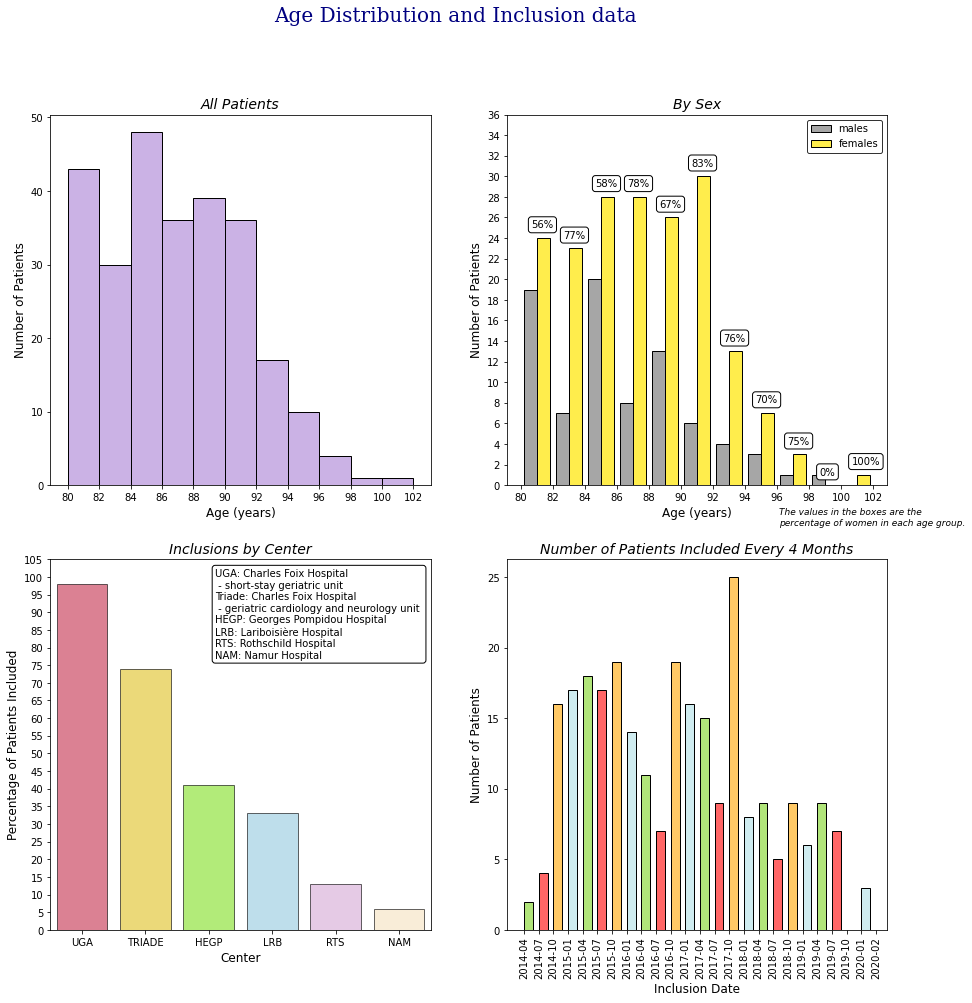

In [44]:
male_rgb = (0.5, 0.5, 0.5, 0.7)
female_rgb = (1.0, 0.9, 0.0, 0.7)

##Viz 1: Age distribution and inclusion
bins = range(int(patients.age.min()), int(patients.age.max()) + 4, 2)
hist_females, _ = np.histogram(patients.age[patients['sex'] == 1], bins = bins)
hist_males, _ = np.histogram(patients.age[patients['sex'] == 0], bins = bins)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15))
fig.suptitle('Age Distribution and Inclusion data', fontdict = fontdict_title, fontsize = 20)
#plt.subplots_adjust(top=0.85)

#Age distribution of ADAGE patients
ax[0,0].hist(patients.age, bins = bins, color = (0.6, 0.4, 0.8, 0.5), edgecolor = 'black')
ax[0,0].set_xticks(range(int(patients.age.min()), int(patients.age.max())+3,2))

ax[0,0].set_xlabel('Age (years)', fontdict = {'size' : '12'})
ax[0,0].set_ylabel('Number of Patients', fontdict = {'size' : '12'})
ax[0,0].set_title(f'All Patients', fontdict = fontdict_subtitle)

#Age distribution by sex

ax[0,1].hist([patients.age[patients['sex'] == 0], patients.age[patients['sex'] == 1]], bins = bins, color = [male_rgb, female_rgb], edgecolor = 'black', label = ['males', 'females'])
ax[0,1].set_yticks(range(0, max(max(hist_females), max(hist_males))+8, 2))
ax[0,1].set_xticks(range(int(patients.age.min()), int(patients.age.max()) + 4,2))
ax[0,1].legend(edgecolor = 'black')

ax[0,1].set_xlabel('Age (years)', fontdict = {'size' : '12'})
ax[0,1].set_ylabel('Number of Patients', fontdict = {'size' : '12'})
ax[0,1].set_title('By Sex', fontdict = fontdict_subtitle)
ax[0,1].grid(False)

fig.text(0.8, 0.5, 'The values in the boxes are the \npercentage of women in each age group.', fontdict={'style' : 'italic', 'size' : '9'})

x_0 = 80.65

for n_fem, n_mal in zip(hist_females, hist_males):
    ax[0,1].text(x_0, (n_fem+1), f'{100*n_fem/(n_fem+n_mal):0.0f}%', bbox = {'facecolor' : 'white', 'edgecolor' : 'black', 'boxstyle' : 'round'})
    x_0 += 2

#Inclusions distribution in every center    
histvalues = pd.DataFrame({'center' : patients.center_incl.value_counts().index, 'val' : patients.center_incl.value_counts().values})
sns.barplot(x='center', y='val', data=histvalues, ax = ax[1,0], edgecolor = 'black', palette = [(0.863, 0.078, 0.235), (1.0, 0.843, 0.0), (0.498, 1.0, 0.0), (0.529, 0.808, 0.922), (0.867, 0.627, 0.867), (1.0, 0.894, 0.71)], alpha = 0.6)

ax[1,0].set_yticks(range(0,int(histvalues['val'].max()*1.1),5))
ax[1,0].set_xlabel('Center', fontdict = {'size' : '12'})
ax[1,0].set_ylabel('Percentage of Patients Included', fontdict = {'size' : '12'})
ax[1,0].set_title('Inclusions by Center', fontdict = fontdict_subtitle)
ax[1,0].grid(False)
ax[1,0].text(2.1, 77, 'UGA: Charles Foix Hospital \n - short-stay geriatric unit \nTriade: Charles Foix Hospital \n - geriatric cardiology and neurology unit \nHEGP: Georges Pompidou Hospital \nLRB: Lariboisière Hospital \nRTS: Rothschild Hospital \nNAM: Namur Hospital',
             fontdict = {'size' : '10'}, bbox = {'facecolor' : 'white', 'edgecolor' : 'black', 'boxstyle' : 'round'})

#Inclusions per quarter

patient_counts = patients.groupby(pd.Grouper(key='incl_date', freq='3MS')).size()

bar_width = 0.6
bar_positions = np.arange(len(patient_counts))
ax[1,1].bar(bar_positions, patient_counts, width=bar_width, edgecolor='black', color = [(0.49, 0.83, 0.13, 0.6), (1.0, 0.0, 0.0, 0.6), (1.0, 0.65, 0.0, 0.6), (0.69, 0.88, 0.9, 0.6)])

start_date = patient_counts.index[0].replace(day=1)
end_date = patient_counts.index[-1] + pd.offsets.MonthEnd(1)
xtick_positions = np.arange(len(patient_counts)+1) - bar_width / 2
xtick_labels = sorted(pd.date_range(start=start_date, end=end_date, freq='3MS').strftime('%Y-%m'))
xtick_labels.append(patients.incl_date.max().strftime('%Y-%m'))
ax[1,1].set_xticks(xtick_positions)
ax[1,1].set_xticklabels(xtick_labels, rotation=90)

ax[1,1].set_xlabel('Inclusion Date', size = '12')
ax[1,1].set_ylabel('Number of Patients', size = '12')
ax[1,1].set_title('Number of Patients Included Every 4 Months', fontdict = fontdict_subtitle)
ax[1,1].grid(False)

plt.show()

patients2 = patients[['age', 'sex']].dropna()
ttest_age_sex, pval_age_sex = ttest_ind(patients2.age[patients2['sex'] == 1], patients2.age[patients2['sex'] == 0])


display(HTML(f"""<div>The study recruited patients between  {patients.incl_date.min().strftime('%m/%Y')} and {patients.incl_date.max().strftime('%m/%Y')}. With a total of <b>{len(patients)}</b>
    patients included. The mean age of the patients was <b>{patients.age.mean():.1f}</b> ± {patients.age.std():.1f} years (min-max: {patients.age.min():.1f} - {patients.age.max():.1f} years)
    and the majority of patients ({patients.sex.value_counts()[1]/len(patients):.1%}) were females, which is expected in this population. On average, females were {int(ttest_age_sex)} years older
    than males (<i>p</i>-value = {pval_age_sex:.4f}). The inclusion process was uneven across centers, with {len(patients[(patients['center_incl'] == 'TRIADE') | (patients['center_incl'] == 'UGA')])/len(patients):.1%} of patients
    recruited from either short-stay geriatric unit (UGA) or geriatric cardiology and neurology unit (Triade) in Charles Foix Hospital.
    The majority of patients ({len(patients[(patients['incl_date'] > pd.to_datetime('2014-09')) & (patients['incl_date'] < pd.to_datetime('2018-01'))])/len(patients):.1%}) were included betwen October 2014 and January 2018 regardless of center.
    Interestingly, most patients were recruited during the autumn months ({len(patients[patients['incl_season'] == 'autumn'])/len(patients):.1%}) and least during the summer months ({len(patients[patients['incl_season'] == 'summer'])/len(patients):.1%}).
</div>
"""))
fig.savefig('age_distribution_inclusion.png')

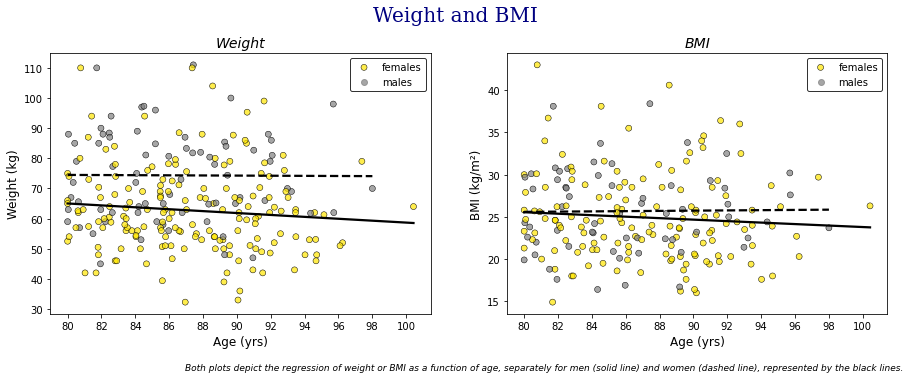

In [10]:
##Viz 2: Weight and BMI

fig2, ax2 = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
fig2.suptitle('Weight and BMI', fontdict = fontdict_title, fontsize = 20)
plt.subplots_adjust(top=0.85)

#Weight as a function of age
ax2[0].set_title('Weight', fontdict = fontdict_subtitle)
sns.scatterplot(x = 'age', y = 'weight', data = patients, hue = 'sex', label = [], palette = [male_rgb, female_rgb], edgecolor = 'black', ax = ax2[0])
sns.regplot(x='age', y='weight', data=patients[patients['sex'] == 1], scatter=False, ci = None, color = 'black', ax = ax2[0])
sns.regplot(x='age', y='weight', data=patients[patients['sex'] == 0], scatter=False, ci = None, color = 'black', line_kws = {'linestyle' : '--'}, ax = ax2[0])

ax2[0].set_ylabel('Weight (kg)', size = '12')
ax2[0].set_xlabel('Age (yrs)', size='12')
ax2[0].set_xticks(range(int(min(patients.age)), int(max(patients.age)+2), 2))
ax2[0].legend(labels = ['females', 'males'], edgecolor = 'black')

#BMI as a function of age
ax2[1].set_title('BMI', fontdict = fontdict_subtitle)
sns.scatterplot(x = 'age', y = 'bmi', data = patients, hue = 'sex', label = [], palette = [male_rgb, female_rgb], edgecolor = 'black', ax = ax2[1])
sns.regplot(x='age', y='bmi', data=patients[patients['sex'] == 1], scatter=False, ci = None, color = 'black', ax = ax2[1])
sns.regplot(x='age', y='bmi', data=patients[patients['sex'] == 0], scatter=False, ci = None, color = 'black', line_kws = {'linestyle' : '--'}, ax = ax2[1])

ax2[1].set_ylabel('BMI (kg/m²)', size = '12')
ax2[1].set_xlabel('Age (yrs)', size = '12')
ax2[1].set_xticks(range(int(min(patients.age)), int(max(patients.age)+2), 2))
ax2[1].legend(labels = ['females', 'males'], edgecolor = 'black')

fig2.text(0.25, -0.03, 'Both plots depict the regression of weight or BMI as a function of age, separately for men (solid line) and women (dashed line), represented by the black lines.',
         fontdict = fontdict_addinfo)
plt.show()

ttest_weight_sex, pval_weight_sex = ttest_ind(patients.weight[patients['sex'] == 0].dropna(), patients.weight[patients['sex'] == 1].dropna())
ttest_bmi_sex, pval_bmi_sex = ttest_ind(patients.bmi[patients['sex'] == 0].dropna(), patients.bmi[patients['sex'] == 1].dropna())


display(HTML(f'''
The Average weight and BMI of <span style="font-variant: small-caps;">Adage</span> patients were of <b>{np.mean(patients.weight):.1f}</b> ± <b>{np.std(patients.weight):.1f}</b> kg and <b>{np.mean(patients.bmi):.1f}</b> ± <b>{np.std(patients.bmi):.1f}</b> kg/m², respectively.
The weight of the patients ranged from {np.min(patients.weight):.1f} to {np.max(patients.weight):.1f} kg and it was found to be correlated with sex. Men had an average weight that was 
{ttest_weight_sex:.1f} kg heavier than women ({pval_txt(pval_weight_sex)}). On the other hand, the BMI was not found to be influenced by sex ({pval_txt(pval_bmi_sex)}).
'''))

demographics_table = f"<style>{css_style}</style>" + f'''
<table class="my-table">
<caption>ADAGE patient demographics</caption>

    <thead>
        <tr>
            <th></th>
            <th>Age (yr)</th>
            <th>Weight (kg)</th>
            <th>BMI (kg/m²)</th>
            <th></th>
            <th></th>
            <th>females</th>
            <th>males</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><i>mean</i></td>
            <td>{round(np.mean(patients.age),1)}</td>
            <td>{round(np.mean(patients.weight),1)}</td>
            <td>{round(np.mean(patients.bmi),1)}</td>
            <td></td>
            <td><i>n</i></td>
            <td>{patients.sex.value_counts()[1]}</td>
            <td>{patients.sex.value_counts()[0]}</td>
        </tr>
        <tr>
            <td><i>std</i></td>
            <td>{round(np.std(patients.age),1)}</td>
            <td>{round(np.std(patients.weight),1)}</td>
            <td>{round(np.std(patients.bmi),1)}</td>
            <td></td>
            <td><i>%</i></td>
            <td>{round(100*patients.sex.value_counts()[1]/len(patients.sex),1)}</td>
            <td>{round(100*patients.sex.value_counts()[0]/len(patients.sex),1)}</td>
        </tr>
        <tr>
            <td><i>median</i></td>
            <td>{round(np.nanmedian(patients.age),1)}</td>
            <td>{round(np.nanmedian(patients.weight),1)}</td>
            <td>{round(np.nanmedian(patients.bmi),1)}</td>
        </tr>
        <tr>
            <td><i>IQR</i></td>
            <td>{round(np.nanpercentile(patients.age, 25),1)} - {round(np.nanpercentile(patients.age, 75),1)} </td>
            <td>{round(np.nanpercentile(patients.weight, 25),1)} - {round(np.nanpercentile(patients.weight, 75),1)} </td>
            <td>{round(np.nanpercentile(patients.bmi, 25),1)} - {round(np.nanpercentile(patients.bmi, 75),1)} </td>
        </tr>
        <tr>
            <td><i>min - max</i></td>
            <td>{round(np.min(patients.age),1)} - {round(np.max(patients.age),1)} </td>
            <td>{round(np.min(patients.weight),1)} - {round(np.max(patients.weight),1)}</td>
            <td>{round(np.min(patients.bmi),1)} - {round(np.max(patients.bmi),1)} </td>
        </tr>
     </tbody>
     <tfoot>
        <tr>
            <td colspan="8">Legend goes here proot proot proot</td>
        </tr>
    </tfoot>
</table>
        
'''

display(HTML(demographics_table))


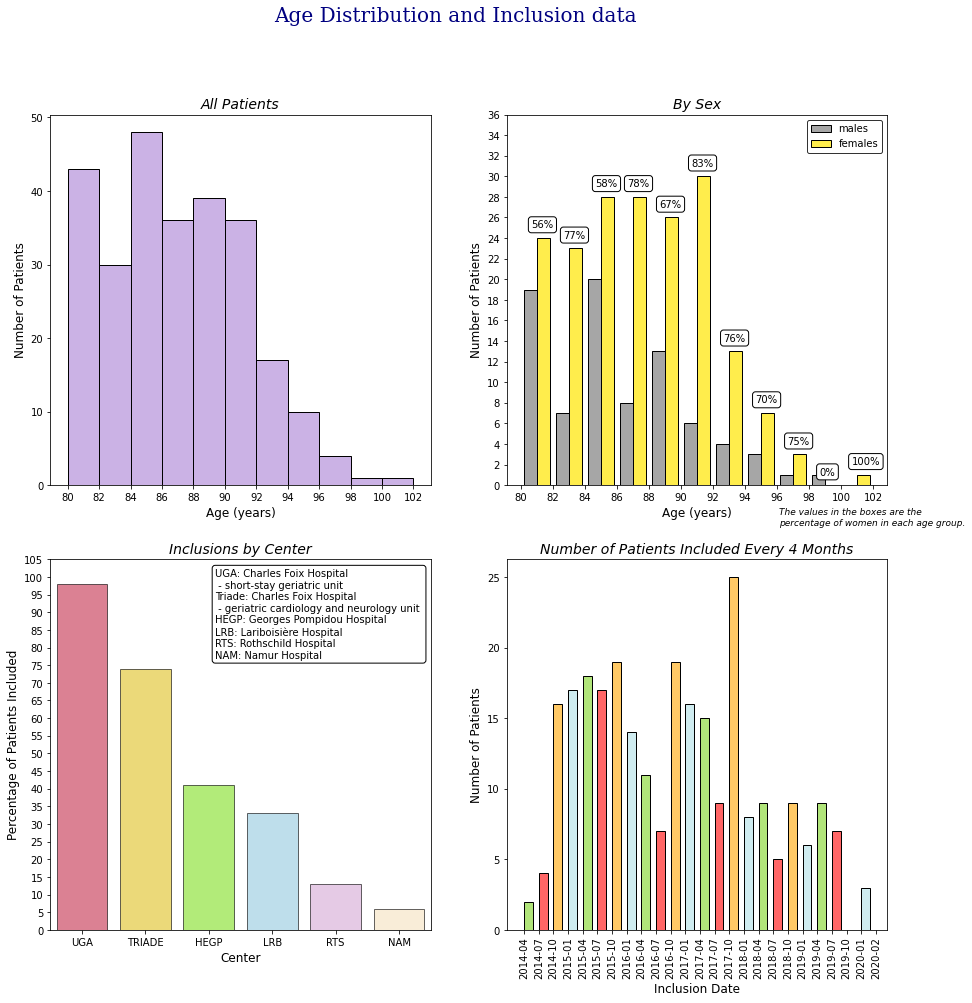

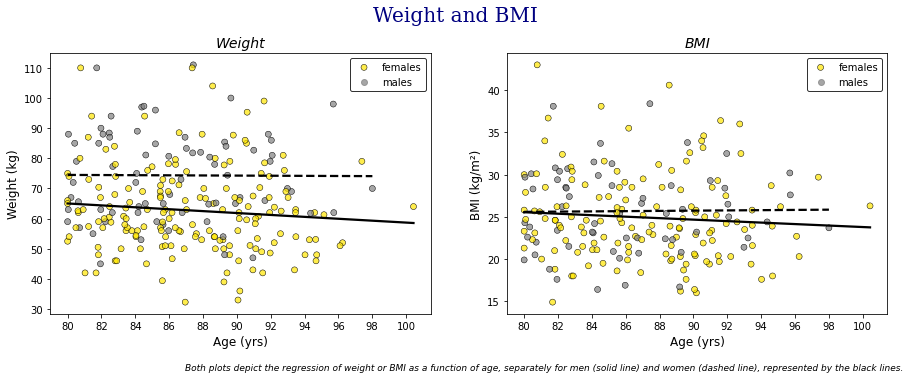

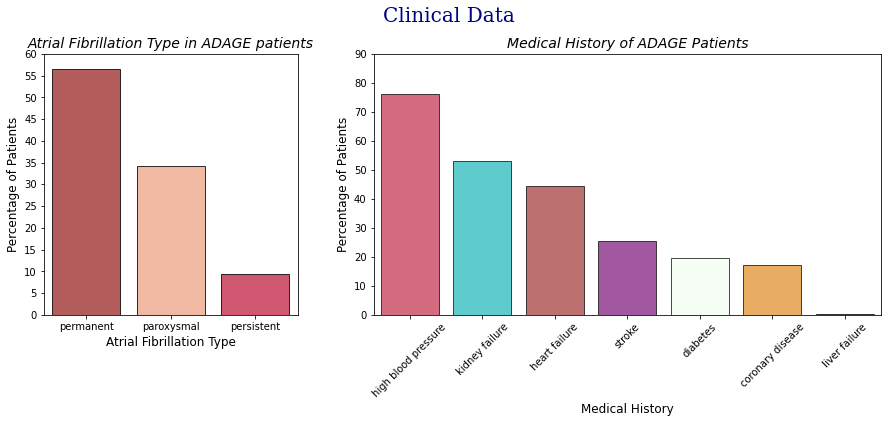

,CHA2DS2VASc,HEMORR2HAGES,HAS-BLED,CIRS-G
mean ± std,5.0 ± 1.4,2.3 ± 1.0,1.6 ± 0.7,10.3 ± 4.4
median (IQR),5 (4 - 6),2 (2 - 3),1 (1 - 2),10 (7 - 12)
min - max,2 - 9,1 - 6,0 - 4,3 - 27


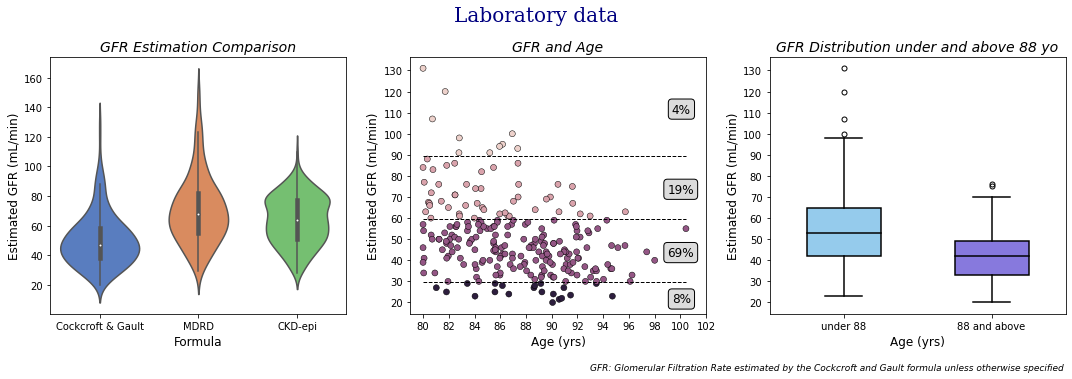

,haemoglobin (g/dL),platelets (G/L),leucocytes (G/L),fibrinogen (g/L),albumin (g/L),creatinine (µmol/L)
mean ± std,12.1 ± 1.7,254.8 ± 92.7,8.2 ± 3.2,4.0 ± 1.0,33.1 ± 5.2,82.7 ± 24.4
median (IQR),12.2 (11.1 - 13.3),238.0 (193.0 - 291.0),7.5 (6.1 - 9.6),3.9 (3.3 - 4.6),33.0 (30.0 - 36.6),78.0 (65.0 - 99.0)
min - max,8.0 - 16.3,93.0 - 770.0,3.2 - 23.1,2.0 - 7.5,18.9 - 46.0,36.0 - 190.0


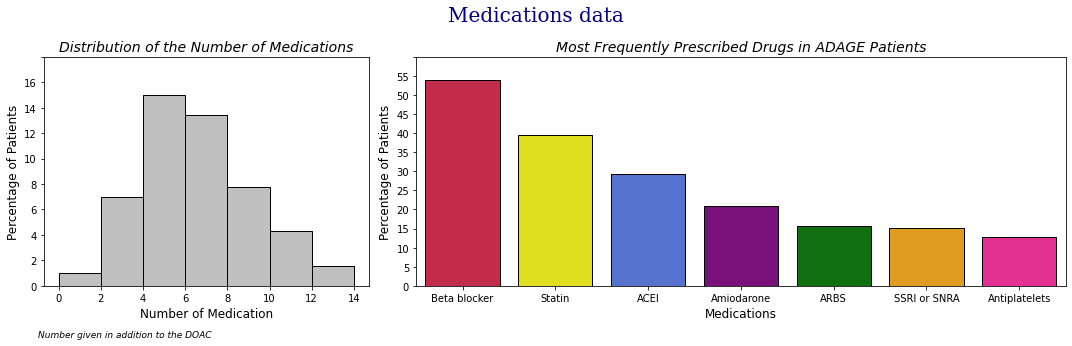

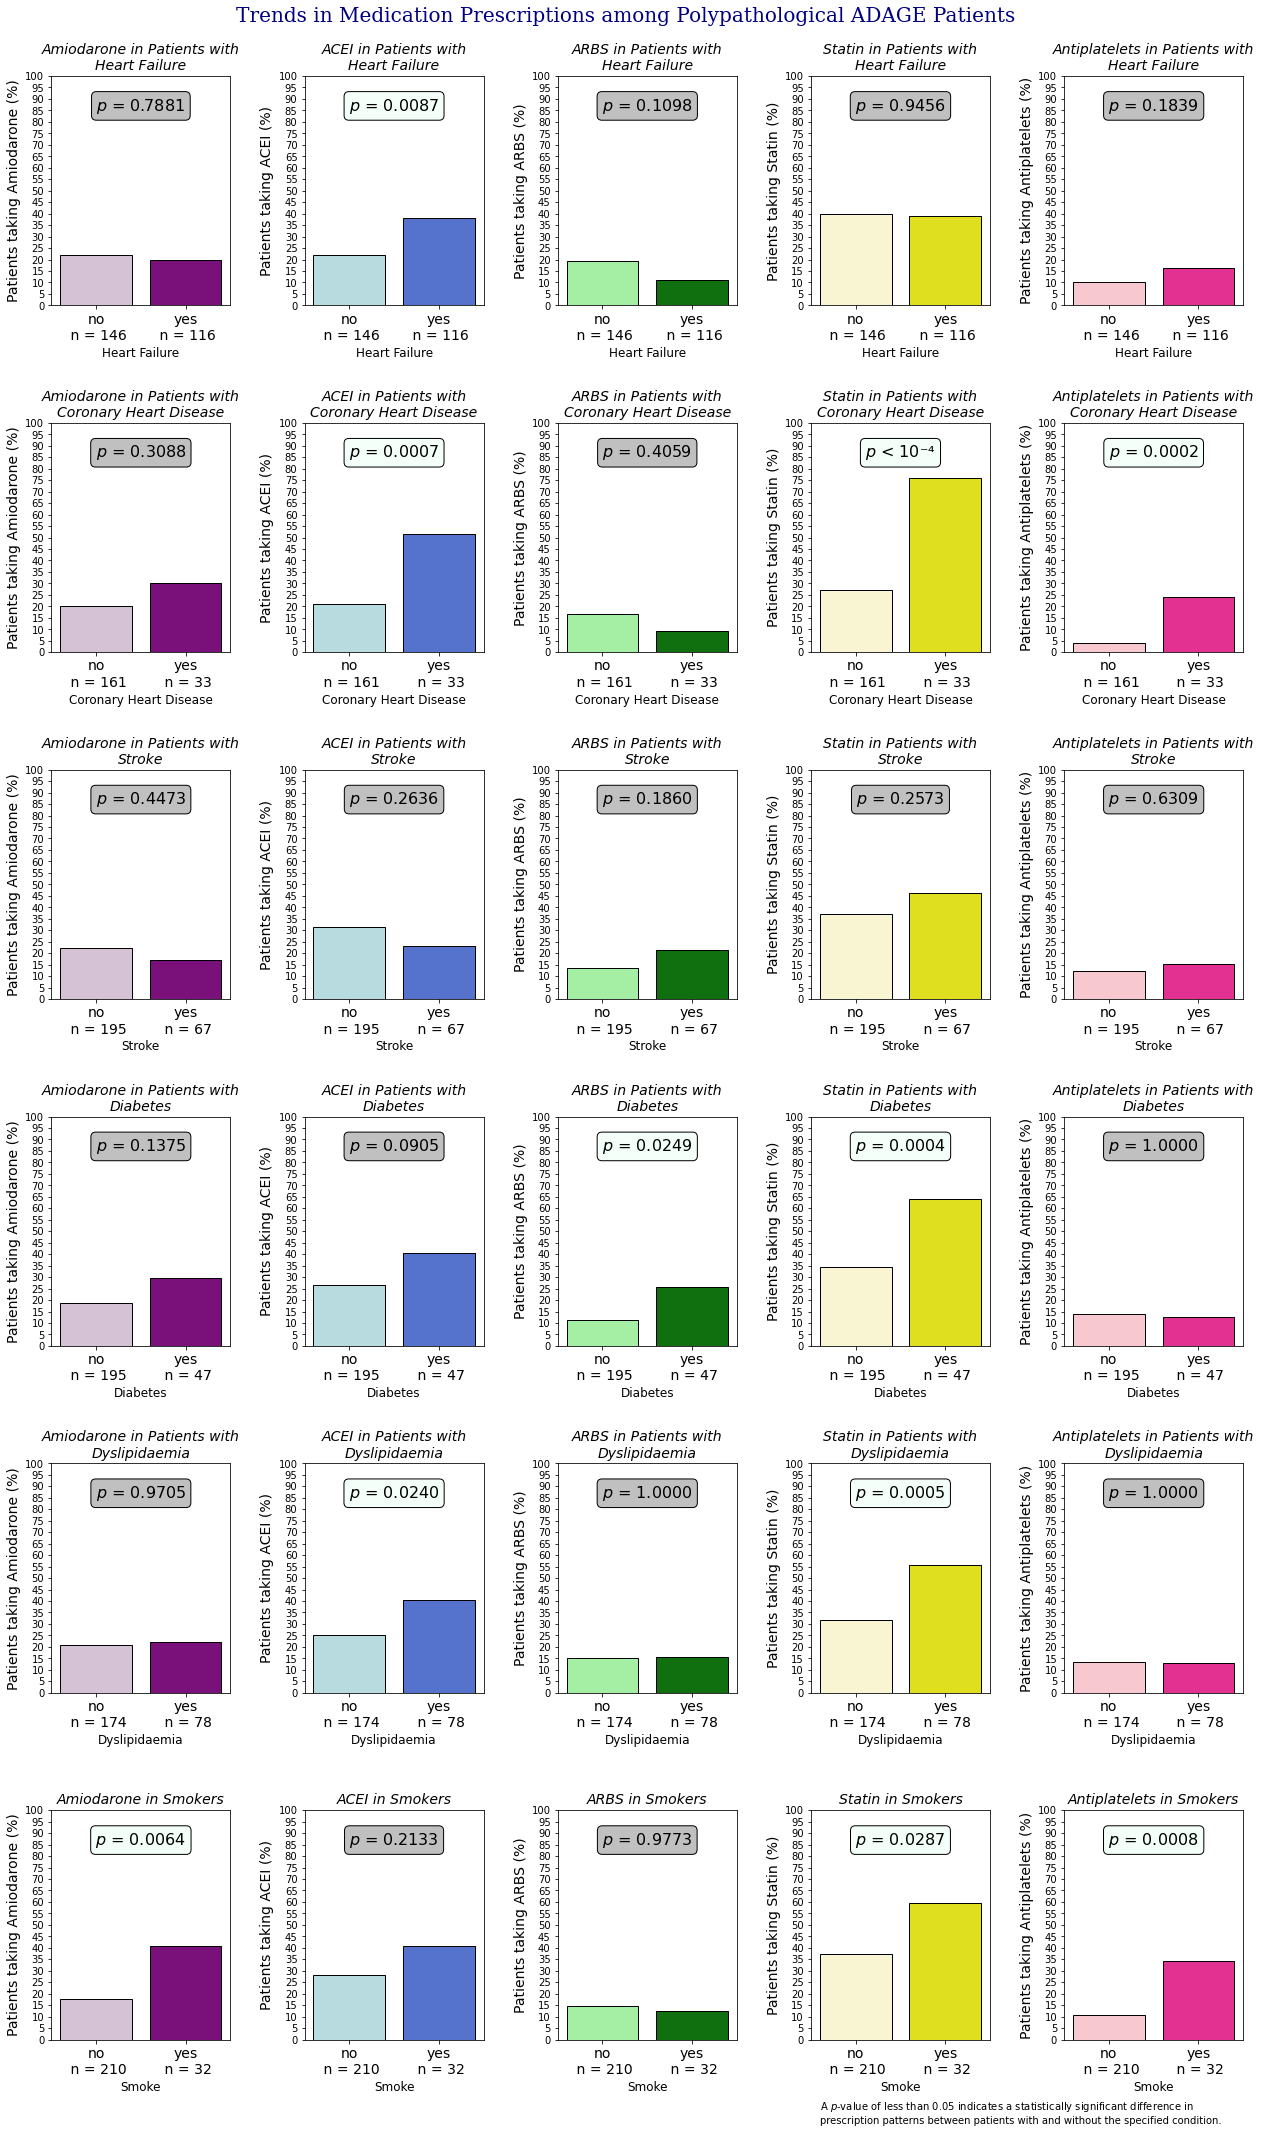

In [6]:





##Viz 3: Clinical data
fig3, (ax3_1, ax3_2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5), gridspec_kw = {'width_ratios' : [1,2]})
fig3.suptitle('Clinical Data', fontdict = fontdict_title, fontsize = 20)
plt.subplots_adjust(top=0.85)

#FA types
    #Creating a df that stores af types as % of patients
af_type_df = pd.DataFrame({'af_type' : ['paroxysmal' if x == 1.0 else('persistent' if x == 2.0 else('permanent' if x == 3.0 else(x))) for x in patients.fa_type.value_counts().keys()], 'values' : patients.fa_type.value_counts(normalize=True).tolist()}).sort_values('values', ascending = False)
sns.barplot(x = 'af_type', y = 'values', data = af_type_df, palette = ['firebrick', 'lightsalmon', 'crimson'], alpha = 0.8, edgecolor = 'black', ax = ax3_1)

ax3_1.set_yticks([x/100 for x in range(0,65,5)])
ax3_1.set_yticklabels([x for x in range(0,65,5)])
ax3_1.set_xlabel('Atrial Fibrillation Type', size = 12)
ax3_1.set_ylabel('Percentage of Patients', size = 12)
ax3_1.set_title('Atrial Fibrillation Type in ADAGE patients', fontdict = fontdict_subtitle)
#ax3_1.grid(axis = 'y', color = 'lightgrey', alpha = 0.4)

#Medical history of ADAGE patients
    #Creating a df that stores medical history data as % of patients
list_diseases = ['heartf', 'liverf','coronary', 'stroke', 'diabetes', 'high_bp', 'kidneyf_50']
list_percentages = [patients[x].value_counts(normalize = True)[1] for x in list_diseases]

dis_viz = dict(zip(['disease', 'value'],[list_diseases, list_percentages]))
dis_viz_df = pd.DataFrame(dis_viz).sort_values('value', ascending = False)
dis_viz_df = dis_viz_df.reset_index(drop=True)

sns.barplot(x = 'disease', y = 'value', data = dis_viz_df, ax = ax3_2, edgecolor = 'black', palette = ['crimson', 'darkturquoise', 'firebrick', 'darkmagenta', 'honeydew', 'darkorange', 'maroon'], alpha = 0.7)

ax3_2.set_yticks([x/10 for x in range(0,10,1)])
ax3_2.set_yticklabels(range(0,100,10))
ax3_2.set_xticklabels(['high blood pressure','kidney failure','heart failure', 'stroke', 'diabetes', 'coronary disease','liver failure'], rotation = 45)
ax3_2.set_ylabel('Percentage of Patients', fontsize = 12)
ax3_2.set_xlabel('Medical History', fontsize = 12)
ax3_2.set_title('Medical History of ADAGE Patients', fontdict = fontdict_subtitle)

plt.show()


display(HTML(f'''
All patients included in the cohort suffered from atrial fibrillation (AF) as it was a mandatory inclusion criterion. Among the patients, {af_type_df.iloc[af_type_df.index[af_type_df['af_type'] == 'permanent'][0]]['values']:.1%} were diagnosed with permanent AF,
while {af_type_df.iloc[af_type_df.index[af_type_df['af_type'] == 'paroxysmal'][0]]['values']:.1%} were diagnosed with paroxysmal AF. Only {af_type_df.iloc[af_type_df.index[af_type_df['af_type'] == 'persistent'][0]]['values']:.1%} were diagnosed with 
persistent AF. In terms of medical history, <span style="font-variant : small-caps";>Adage</span> patients were found to have multiple medical conditions with an average CIRS-G score of {np.mean(patients.cirsg_tot):.1f}. The most prevalent associated pathologies were hypertension
({dis_viz_df.iloc[dis_viz_df.index[dis_viz_df['disease'] == 'high_bp'][0]]['value']:.1%}), kidney failure (glomerular filtration rate < 50 mL/min according to Cockcroft formula - {dis_viz_df.iloc[dis_viz_df.index[dis_viz_df['disease'] == 'kidneyf_50'][0]]['value']:.1%}) 
and heart failure ({dis_viz_df.iloc[dis_viz_df.index[dis_viz_df['disease'] == 'heartf'][0]]['value']:.1%}). It is noteworthy that quarter of patients had an history of stroke and the
mean Cha2ds2Vasc score was {np.mean(patients.chadsvasc_score):.1f} ± {np.std(patients.chadsvasc_score):.1f}. The table below provides additional clinical scores.

<table>
    <caption>Clinical scores</caption>
        <thead>
            <tr>
                <th></th>
                <th>CHA2DS2VASc</th>
                <th>HEMORR2HAGES</th>
                <th>HAS-BLED</th>
                <th>CIRS-G</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>mean ± std</td>
                <td>{np.mean(patients.chadsvasc_score):.1f} ± {np.std(patients.chadsvasc_score):.1f}</td>
                <td>{np.mean(patients.hemorrhages_score):.1f} ± {np.std(patients.hemorrhages_score):.1f}</td>
                <td>{np.mean(patients.hasbled_score):.1f} ± {np.std(patients.hasbled_score):.1f}</td>
                <td>{np.mean(patients.cirsg_tot):.1f} ± {np.std(patients.cirsg_tot):.1f}</td>
            </tr>
            <tr>
                <td>median (IQR)</td>
                <td>{np.median(patients.chadsvasc_score.dropna()):.0f} ({np.percentile(patients.chadsvasc_score.dropna(), 25):.0f} - {np.percentile(patients.chadsvasc_score.dropna(), 75):.0f})</td>
                <td>{np.median(patients.hemorrhages_score.dropna()):.0f} ({np.percentile(patients.hemorrhages_score.dropna(), 25):.0f} - {np.percentile(patients.hemorrhages_score.dropna(), 75):.0f})</td>
                <td>{np.median(patients.hasbled_score.dropna()):.0f} ({np.percentile(patients.hasbled_score.dropna(), 25):.0f} - {np.percentile(patients.hasbled_score.dropna(), 75):.0f})</td>
                <td>{np.median(patients.cirsg_tot.dropna()):.0f} ({np.percentile(patients.cirsg_tot.dropna(), 25):.0f} - {np.percentile(patients.cirsg_tot.dropna(), 75):.0f})</td>
            </tr>
            <tr>
                <td>min - max</td>
                <td>{np.min(patients.chadsvasc_score):.0f} - {np.max(patients.chadsvasc_score):.0f}</td>
                <td>{np.min(patients.hemorrhages_score):.0f} - {np.max(patients.hemorrhages_score):.0f}</td>
                <td>{np.min(patients.hasbled_score):.0f} - {np.max(patients.hasbled_score):.0f}</td>
                <td>{np.min(patients.cirsg_tot):.0f} - {np.max(patients.cirsg_tot):.0f}</td>
            </tr>
        </tbody>
</table>
            
                
                

'''))

##Viz 4: Laboratory data
fig4, ax4 = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))
fig4.suptitle('Laboratory data', fontdict = fontdict_title, fontsize = 20)


#Compairing ClCr formulae
sns.violinplot(data=patients[['clcr_cockcroft', 'clcr_mdrd', 'clcr_ckdepi']], palette='muted', inner='box', ax = ax4[0])

ax4[0].set_xticklabels(['Cockcroft & Gault', 'MDRD', 'CKD-epi'])
ax4[0].set_xlabel('Formula', size = 12)
ax4[0].set_ylabel('Estimated GFR (mL/min)', size = 12)
ax4[0].set_title('GFR Estimation Comparison', fontdict = fontdict_subtitle)


#ClCr as a function of age
sns.scatterplot(x = 'age', y = 'clcr_cockcroft', data = patients, ax = ax4[1], hue = 'kidneyf_class', palette = [[0.931, 0.820, 0.797],
[0.855, 0.641, 0.675], [0.579, 0.339, 0.521], [0.175, 0.118, 0.242]], edgecolor = 'black', legend = False)
ax4[1].plot([patients.age.min(),patients.age.max()],[89.5,89.5], linewidth = 1, linestyle = 'dashed', color = 'black')
ax4[1].plot([patients.age.min(),patients.age.max()],[59.5,59.5], linewidth = 1, linestyle = 'dashed', color = 'black')
ax4[1].plot([patients.age.min(),patients.age.max()],[29.5,29.5], linewidth = 1, linestyle = 'dashed', color = 'black')

ax4[1].text(99.35, 110, f'{patients.kidneyf_class.value_counts(normalize = True)[0.0]:.0%}', size = 12, bbox = {'facecolor' : 'gainsboro', 'edgecolor' : 'black', 'boxstyle' : 'round'})
ax4[1].text(99, 72, f'{patients.kidneyf_class.value_counts(normalize = True)[1.0]:.0%}', size = 12, bbox = {'facecolor' : 'gainsboro', 'edgecolor' : 'black', 'boxstyle' : 'round'})
ax4[1].text(99, 42, f'{patients.kidneyf_class.value_counts(normalize = True)[2.0]:.0%}', size = 12, bbox = {'facecolor' : 'gainsboro', 'edgecolor' : 'black', 'boxstyle' : 'round'})
ax4[1].text(99.35, 20, f'{patients.kidneyf_class.value_counts(normalize = True)[3.0]:.0%}', size = 12, bbox = {'facecolor' : 'gainsboro', 'edgecolor' : 'black', 'boxstyle' : 'round'})


ax4[1].set_xticks(range(int(patients.age.min()), int(patients.age.max()+3), 2))
ax4[1].set_xlabel('Age (yrs)', size = 12)
ax4[1].set_yticks(range(int(patients.clcr_cockcroft.min()), int(patients.clcr_cockcroft.max()), 10))
ax4[1].set_ylabel('Estimated GFR (mL/min)', size = 12)
ax4[1].set_title('GFR and Age', fontdict = fontdict_subtitle)


#ClCr distribution with age cut-off of 88
patients['cutoff_clcr'] = patients['age'].apply(lambda x: 0 if x < 88 else 1)
sns.boxplot(y = 'clcr_cockcroft', x = 'cutoff_clcr', data = patients, ax = ax4[2], width = 0.5, palette = ['lightskyblue', 'mediumslateblue'], boxprops = {'edgecolor': 'black'}, whiskerprops = {'color' : 'black'}, medianprops = {'color' : 'black'}, capprops={'color': 'black'}, flierprops = {'marker' : 'o', 'markerfacecolor' : 'None', 'markeredgecolor' : 'black'})

ax4[2].set_xticklabels(['under 88', '88 and above'])
ax4[2].set_xlabel('Age (yrs)', size = 12)
ax4[2].set_yticks(range(int(patients.clcr_cockcroft.min()), int(patients.clcr_cockcroft.max())+9, 10))
ax4[2].set_ylabel('Estimated GFR (mL/min)', size = 12)
ax4[2].set_title('GFR Distribution under and above 88 yo', fontdict = fontdict_subtitle)

fig4.text(0.55, -0.03, 'GFR: Glomerular Filtration Rate estimated by the Cockcroft and Gault formula unless otherwise specified', fontdict = {'fontstyle' : 'italic', 'fontsize' : 9})

plt.tight_layout()
plt.show()

ttest_cockcroft_mdrd, pval_cockcroft_mdrd = ttest_rel(patients[['clcr_cockcroft', 'clcr_mdrd']].dropna()['clcr_mdrd'], patients[['clcr_cockcroft', 'clcr_mdrd']].dropna()['clcr_cockcroft'])

ttest_cockcroft_ckd, pval_cockcroft_ckd = ttest_rel(patients[['clcr_cockcroft', 'clcr_ckdepi']].dropna()['clcr_ckdepi'],patients[['clcr_cockcroft', 'clcr_ckdepi']].dropna()['clcr_cockcroft'])

corr_cockcroft_age, pval_cockcroft_age = spearmanr(patients[['clcr_cockcroft', 'age']].dropna()['clcr_cockcroft'], patients[['clcr_cockcroft', 'age']].dropna()['age'])

display(HTML(f'''
In this study, GFR (glomerular filtration rate) was assessed using three different formulae: Cockcroft & Gault, MDRD and CKD-epi. While some correlations were observed between all three methods, 
significant differences were found in the estimated GFR. On average, compared to the Cockcroft formula, 
the estimated GFR was {ttest_cockcroft_mdrd:.1f} mL/min and {ttest_cockcroft_ckd:.1f} mL/min higher using MDRD (<i>p</i> {pval_txt(pval_cockcroft_mdrd)}) and CKD-epi (<i>p</i> {pval_txt(pval_cockcroft_ckd)}), respectively .
It is known that both MDRD and CKD-epi tend to overestimate GFR in elderly people. Therefore, the Cockcroft & Gault formula was chosen as the gold standard to estimate 
GFR in <span style = "font-variant: small-caps;">Adage</span> patients.
The mean GFR was of {np.mean(patients.clcr_cockcroft):.1f} ± {np.std(patients.clcr_cockcroft):.1f} mL/min.
GFR was found to be negatively correlated with age (<i>p</i> {pval_txt(pval_cockcroft_age)}). Remarkably, the maximum GFR observed in patients aged 88 years and above was {patients[patients['age']>=88]['clcr_cockcroft'].max():.1f} mL/min.
'''))

#idée bokeh : ajouter en hoover % et age moyen dans chaque 

display(HTML(f'''
<table>
<caption></caption>
    <head>
        <thead>
            <tr>
                <th></th>
                <th>haemoglobin (g/dL)</th>
                <th>platelets (G/L)</th>
                <th>leucocytes (G/L)</th>
                <th>fibrinogen (g/L)</th>
                <th>albumin (g/L)</th>
                <th>creatinine (µmol/L)</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>mean ± std</td>
                <td>{np.mean(patients.hb):.1f} ± {np.std(patients.hb):.1f}</td>
                <td>{np.mean(patients.platelets):.1f} ± {np.std(patients.platelets):.1f}</td>
                <td>{np.mean(patients.leucocytes):.1f} ± {np.std(patients.leucocytes):.1f}</td>
                <td>{np.mean(patients.fib):.1f} ± {np.std(patients.fib):.1f}</td>
                <td>{np.mean(patients.albumin):.1f} ± {np.std(patients.albumin):.1f}</td>
                <td>{np.mean(patients.creat):.1f} ± {np.std(patients.creat):.1f}</td>
            </tr>
            <tr>
                <td>median (IQR)</td>
                <td>{np.median(patients.hb.dropna()):.1f} ({np.percentile(patients.hb.dropna(), 25):.1f} - {np.percentile(patients.hb.dropna(), 75):.1f})</td>
                <td>{np.median(patients.platelets.dropna()):.1f} ({np.percentile(patients.platelets.dropna(), 25):.1f} - {np.percentile(patients.platelets.dropna(), 75):.1f})</td>
                <td>{np.median(patients.leucocytes.dropna()):.1f} ({np.percentile(patients.leucocytes.dropna(), 25):.1f} - {np.percentile(patients.leucocytes.dropna(), 75):.1f})</td>
                <td>{np.median(patients.fib.dropna()):.1f} ({np.percentile(patients.fib.dropna(), 25):.1f} - {np.percentile(patients.fib.dropna(), 75):.1f})</td>
                <td>{np.median(patients.albumin.dropna()):.1f} ({np.percentile(patients.albumin.dropna(), 25):.1f} - {np.percentile(patients.albumin.dropna(), 75):.1f})</td>
                <td>{np.median(patients.creat.dropna()):.1f} ({np.percentile(patients.creat.dropna(), 25):.1f} - {np.percentile(patients.creat.dropna(), 75):.1f})</td>
            </tr>
            <tr>
                <td>min - max</td>
                <td>{np.min(patients.hb):.1f} - {np.max(patients.hb):.1f}</td>
                <td>{np.min(patients.platelets):.1f} - {np.max(patients.platelets):.1f}</td>
                <td>{np.min(patients.leucocytes):.1f} - {np.max(patients.leucocytes):.1f}</td>
                <td>{np.min(patients.fib):.1f} - {np.max(patients.fib):.1f}</td>
                <td>{np.min(patients.albumin):.1f} - {np.max(patients.albumin):.1f}</td>
                <td>{np.min(patients.creat):.1f} - {np.max(patients.creat):.1f}</td>
            </tr>
        </tbody>
</table>
'''))

##Viz 5: Medications data

fig5, (ax5_1, ax5_2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5), gridspec_kw = {'width_ratios' : [1,2]})
fig5.suptitle('Medications data', fontdict = fontdict_title, size = 20)

#Number of medication
ax5_1.hist(patients.nb_medications, density = True, bins = 7, color = 'silver', edgecolor = 'black')
ax5_1.set_yticks([x/100 for x in range(0, int(np.histogram(patients.nb_medications.dropna())[1].max()+5),2)])
ax5_1.set_yticklabels([x for x in range(0, int(np.histogram(patients.nb_medications.dropna())[1].max()+3),2)] + [None])

ax5_1.set_ylabel('Percentage of Patients', size = 12)
ax5_1.set_xlabel('Number of Medication', size = 12)
ax5_1.set_title('Distribution of the Number of Medications', fontdict = fontdict_subtitle)
ax5_1.text(-1, -0.04, 'Number given in addition to the DOAC', fontstyle = 'italic', fontsize = 9)

#Therapeutical classes in the cohort

med_values = []
med_names = ['Amiodarone', 'Beta blocker', 'ACEI', 'ARBS', 'Statin', 'Antiplatelets', 'SSRI or SNRA']
for medication in ['amiodarone', 'bblocker', 'acei', 'arbs', 'statin', 'any_anti_plt', 'ssri_snra']:
    med_values.append(patients[medication].value_counts(normalize = True)[1.0])

med_df = pd.DataFrame({'medications' : med_names, 'val' : med_values})
med_df = med_df.sort_values('val', ascending = False)

    
sns.barplot(x = 'medications', y = 'val', data = med_df, ax = ax5_2, palette = {'Amiodarone' : 'darkmagenta', 'Beta blocker' : 'crimson', 'Statin' : 'yellow', 'Antiplatelets' : 'deeppink', 'ACEI' : 'royalblue', 'ARBS' : 'green', 'SSRI or SNRA' : 'orange' }, edgecolor = 'black')

ax5_2.set_yticks([x/100 for x in range(0, int(med_df.val.max()*100+10),5)])
ax5_2.set_yticklabels([x for x in range(0, int(med_df.val.max()*100+4),5)] + [None])
ax5_2.set_ylabel('Percentage of Patients', size = 12) 
ax5_2.set_xlabel('Medications', size = 12)
ax5_2.set_title('Most Frequently Prescribed Drugs in ADAGE Patients', fontdict = fontdict_subtitle)

plt.tight_layout()
plt.show()

display(HTML(f'''
In the <span style= "font-variant: small-caps;">Adage</span> cohort patients were taking an average of {patients.nb_medications.mean():.1f}
medications per day along with their DOAC. Among the medications prescribed, beta-blockers ({patients.bblocker.value_counts(normalize = True)[1.0]:.1%}) and statins ({patients.statin.value_counts(normalize = True)[1.0]:.1%}) were the most commonly used.
Additionally, {patients.amiodarone.value_counts(normalize = True)[1.0]:.1%} of the cohort were treated with amiodarone, while the use of other antiarrhythmic drugs was negligible.
A minority {patients.any_anti_plt.value_counts(normalize = True)[1.0]:.1%} of patients were treated with an antiplatelet agent, with the majority 
({patients[patients['any_anti_plt'] == 1.0].aspirin.value_counts(normalize = True)[1.0]:.1%}) of those patients receiving aspirin.
'''))

## VIZ 6 Trends in prescription in specific conditions
lst_patho = ['heartf', 'coronary', 'stroke', 'diabetes', 'dyslipidaemia', 'smoke']
patho_titles = {'heartf' : 'Heart Failure', 'coronary' : 'Coronary Heart Disease', 'stroke' : 'Stroke', 'diabetes' : 'Diabetes', 'dyslipidaemia' : 'Dyslipidaemia', 'smoke' : 'Smoke', 'obesity' : 'Obesity'}
lst_medic = ['amiodarone', 'acei', 'arbs', 'statin', 'any_anti_plt']
medic_titles = {'amiodarone' : ['Amiodarone', 'thistle' ,'darkmagenta'], 
                'acei' : ['ACEI', 'powderblue', 'royalblue'],
                'arbs' : ['ARBS','palegreen', 'green'],
                'statin' : ['Statin', 'lemonchiffon', 'yellow'],
                'any_anti_plt' : ['Antiplatelets', 'pink', 'deeppink']}

fig6, ax6 = plt.subplots(nrows = len(lst_patho), ncols = len(lst_medic), figsize = (3*len(lst_patho), 6*len(lst_medic)))
fig6.suptitle('Trends in Medication Prescriptions among Polypathological ADAGE Patients', fontdict = fontdict_title, size = 20)



for patho in lst_patho:
    for medic in lst_medic:
        
        chi2_ij, pval_ij, dof, expected = chi2_contingency(pd.crosstab(patients[[patho, medic]].dropna()[patho], patients[[patho, medic]].dropna()[medic]))
        
        sns.barplot(x = patho, y = medic, data = patients[[patho, medic]].dropna(), ax = ax6[lst_patho.index(patho), lst_medic.index(medic)], ci = None, palette = [medic_titles[medic][1], medic_titles[medic][2]], edgecolor = 'black')
        ax6[lst_patho.index(patho), lst_medic.index(medic)].set_yticks([x/100 for x in range(0,101,5)])
        ax6[lst_patho.index(patho), lst_medic.index(medic)].set_yticklabels(range(0,101,5))
        ax6[lst_patho.index(patho), lst_medic.index(medic)].set_xticklabels([f'no\n n = {len(patients[patients[patho] == 0.0])}', f'yes\n n = {len(patients[patients[patho] == 1.0])}'], size = 14)
        ax6[lst_patho.index(patho), lst_medic.index(medic)].set_ylabel(f'Patients taking {medic_titles[medic][0]} (%)', size = 14)
        ax6[lst_patho.index(patho), lst_medic.index(medic)].set_xlabel(patho_titles[patho], size = 12)
        if patho == 'smoke':
            ax6[lst_patho.index(patho), lst_medic.index(medic)].set_title(f'{medic_titles[medic][0]} in Smokers', fontdict = fontdict_subtitle)
        else:
            ax6[lst_patho.index(patho), lst_medic.index(medic)].set_title(f'{medic_titles[medic][0]} in Patients with\n{patho_titles[patho]}', fontdict = fontdict_subtitle)
        if pval_ij <0.05:
            ax6[lst_patho.index(patho), lst_medic.index(medic)].text(0.5, 0.85,'{}'.format(pval_txt(pval_ij)), fontsize = 16, bbox = {'facecolor' : 'mintcream', 'edgecolor' : 'black', 'boxstyle' : 'round'}, ha = 'center')
        else:
            ax6[lst_patho.index(patho), lst_medic.index(medic)].text(0.5, 0.85,'{}'.format(pval_txt(pval_ij)), fontsize = 16, bbox = {'facecolor' : 'silver', 'edgecolor' : 'black', 'boxstyle' : 'round'}, ha = 'center')


fig6.text(0.65, 0.0, "A $\mathit{{p}}$-value of less than 0.05 indicates a statistically significant difference in \nprescription patterns between patients with and without the specified condition.", size = 10)
fig6.tight_layout(pad = 3)

fig6.savefig('patho_medic_chi2')
plt.show()

display(HTML(f'''
When comparing the prescription frequencies of certain medications among patients with different comorbidities, some trends could be identified:
<ul>
    <li>Patients with a history of coronary heart disease were found to have a significant prescription rate of statins ({pval_txt(chi2_pm('coronary', 'statin'))}), antiplatelets ({pval_txt(chi2_pm('coronary', 'any_anti_plt'))}), and ACE inhibitors ({pval_txt(chi2_pm('coronary', 'acei'))}). These medications are indeed commonly prescribed to reduce the risk of cardiovascular events and complications in patients with a history of coronary heart disease.</li>
    <li>Smokers were found to be more likely to receive statins ({pval_txt(chi2_pm('smoke', 'statin'))}) and antiplatelets ({pval_txt(chi2_pm('smoke', 'any_anti_plt'))}) as compared to non-smokers. Of note, {patients[patients['coronary'] == 1.0].smoke.value_counts(normalize = True)[1.0]:.1%} of patients with a history of coronary heart disease were found to be smokers. Furthermore, amiodarone was found to be significantly more commonly prescribed in smokers as compared to non-smokers.</li>
    <li>Patients with diabetes showed a significant increase in treatment with ARBs ({pval_txt(chi2_pm('diabetes', 'arbs'))}), a medication class that was not significantly more prescribed in any other subgroup. Additionally, these patients were more likely to receive statin therapy ({pval_txt(chi2_pm('diabetes', 'statin'))}).</li>
    <li>The use of amiodarone was found to be significantly lower among patients with dementia ({pval_txt(chi2_pm('dementia', 'amiodarone'))}).</li>
    <li>Beta blockers were comonly prescribed, regardless of polypathology.</li>
    <li>No discernible pattern in medication prescriptions was noted among patients with a glomerular filtration rate of less than 50 mL/min.</li>
</ul>
'''))

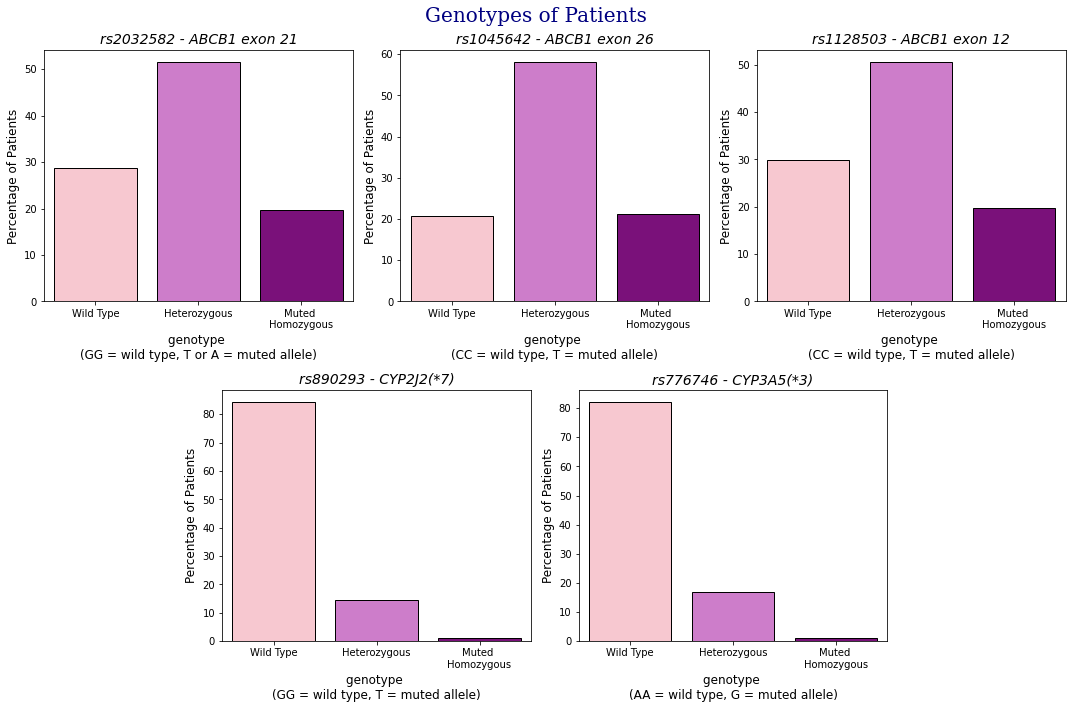

In [7]:
 ##VIZ 7: GENETICS
fig7 = plt.figure(figsize = (15,10))
spec = mpl.gridspec.GridSpec(ncols=6, nrows=2)
subplots = [spec[0,0:2], spec[0,2:4], spec[0,4:], spec[1,1:3], spec[1,3:5]]
   
gene_lst = ['encoded_abcb1_21', 'encoded_abcb1_26', 'encoded_abcb1_12', 'encoded_cyp_2j2', 'encoded_cyp_3a5']
gene_dict = {
    'encoded_abcb1_21': ['rs2032582 - ABCB1 exon 21', 'genotype \n(GG = wild type, T or A = muted allele)'],
    'encoded_abcb1_26': ['rs1045642 - ABCB1 exon 26', 'genotype \n(CC = wild type, T = muted allele)'],
    'encoded_abcb1_12': ['rs1128503 - ABCB1 exon 12', 'genotype \n(CC = wild type, T = muted allele)'], 
    'encoded_cyp_2j2': ['rs890293 - CYP2J2(*7)', 'genotype \n(GG = wild type, T = muted allele)'], 
    'encoded_cyp_3a5': ['rs776746 - CYP3A5(*3)', 'genotype \n(AA = wild type, G = muted allele)']
}
i = 0
fig7.suptitle('Genotypes of Patients', fontdict = fontdict_title, size = 20)

for gene in gene_lst:
    ax = fig7.add_subplot(subplots[i])
    temp_df = pd.DataFrame(patients[gene].value_counts(normalize = True)).sort_index().reset_index().rename(columns={'index': 'genotype'})
    sns.barplot(y = gene, x = 'genotype', data = temp_df, ax = ax, palette = ['pink', 'orchid', 'darkmagenta'], edgecolor = 'black')
    i+=1
    ax.set_xticklabels(['Wild Type', 'Heterozygous', 'Muted \nHomozygous'])
    ax.set_xlabel(gene_dict[gene][1], size = 12)
    ax.set_yticklabels([int(x*100) for x in ax.get_yticks()])
    ax.set_ylabel('Percentage of Patients', size = 12)
    ax.set_title(gene_dict[gene][0], fontdict = fontdict_subtitle)

plt.tight_layout()
plt.show()

display(HTML(f'''The allelic frequency of different variants of <i>ABCB1</i> encoding the P-glycoprotein, 
as well as those of <i>CYP2J2</i> and <i>CYP3A5</i> analysed, does not differ from those reported in the literature for Caucasians 
(source: PharmGKB). None of the studied variants show significant deviation from Hardy-Weinberg equilibrium.
'''))

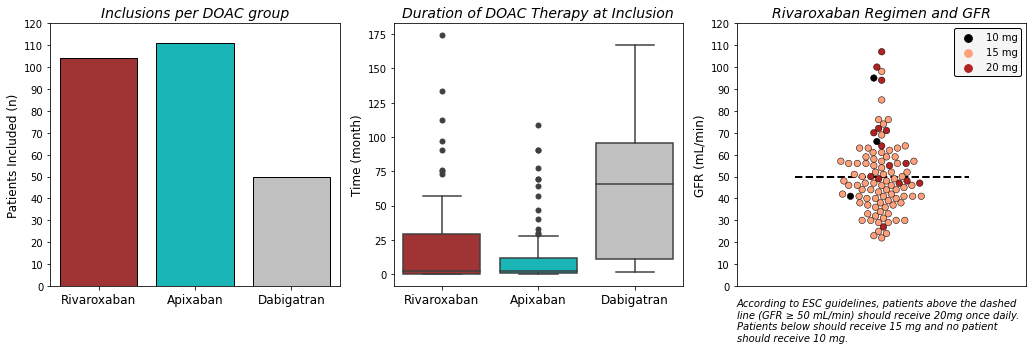

In [24]:
##VIZ 8: DOACS

#Inclusions per DOAC group
fig8, ax8 = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))
sns.countplot(x= 'doac', data = patients,
              ax = ax8[0],
              order = ['R', 'A', 'D'],
              palette = {'A' : 'darkturquoise', 'R' : 'firebrick', 'D' : 'silver'},
              edgecolor = 'black',
              )

ax8[0].set_yticks(range(0, max(patients.doac.value_counts().values) + int(0.1*max(patients.doac.value_counts().values)),10))
ax8[0].set_ylabel('Patients Included (n)', size = 12)
ax8[0].set_xticklabels(['Rivaroxaban', 'Apixaban', 'Dabigatran'], size = 12)
ax8[0].set_xlabel('')
ax8[0].set_title('Inclusions per DOAC group', fontdict = fontdict_subtitle)

#Doac duration at inclusion

sns.boxplot(x= 'doac', y = 'doac_duration', data = patients, order = ['R', 'A', 'D'], ax = ax8[1], palette = {'A' : 'darkturquoise', 'R' : 'firebrick', 'D' : 'silver'}, flierprops = {'marker' : 'o'})

ax8[1].set_ylabel('Time (month)', size = 12)
ax8[1].set_xticklabels(['Rivaroxaban', 'Apixaban', 'Dabigatran'], size = 12)
ax8[1].set_xlabel("")
ax8[1].set_title('Duration of DOAC Therapy at Inclusion', fontdict = fontdict_subtitle)

#same but it's histogram


patients['dosing'] = patients['dosing'].apply(lambda x: '10' if x == 10.0 else ('15' if x == 15.0 else ('20' if x == 20.0 else str(x))))


#sns.swarmplot(x = 'doac', y = 'clcr_cockcroft', hue = 'lower_regimen', data = patients[patients['doac'] != 'D'], ax = ax8[2], palette = [male_rgb, female_rgb], linewidth=0.5, edgecolor='black')
patients['dosing'] = patients['dosing'].astype('str')
sns.swarmplot(x = 'doac', y='clcr_cockcroft', hue = 'dosing', hue_order = ['10', '15', '20'], data=patients[patients['doac'] == 'R'], linewidth=0.5, size = 6.5, palette = ['black', 'lightsalmon', 'firebrick'], edgecolor='black')
#ax8[2].legend(labels=['yes', 'no'], edgecolor='black')

ax8[2].plot([-0.3,0.3],[50, 50], linewidth = 2, linestyle = 'dashed', color = 'black')
#ax8[2].plot([0.6,1.4],[30, 30], linewidth = 1, linestyle = 'dashed', color = 'black')

ax8[2].set_xticks([])
ax8[2].set_xticklabels([], size = 12)
ax8[2].set_yticks(range(0,int(patients[patients['doac'] != 'D'].clcr_cockcroft.max()+20), 10))
ax8[2].set_ylabel('GFR (mL/min)', size = 12)
ax8[2].set_xlabel("")
ax8[2].set_title('Rivaroxaban Regimen and GFR', fontdict = fontdict_subtitle)
#ax8[2].legend(labels = ['10 mg', '15 mg', '20 mg'])

handles, labels = ax8[2].get_legend_handles_labels()

# create a new legend with the desired labels and colors
ax8[2].legend(handles, ["10 mg", "15 mg", "20 mg"], loc="upper right", frameon=True, facecolor="whitesmoke", framealpha=1, edgecolor = 'black')
ax8[2].text(-0.5, -25, 'According to ESC guidelines, patients above the dashed \nline (GFR ≥ 50 mL/min) should receive 20mg once daily. \nPatients below should receive 15 mg and no patient \nshould receive 10 mg.', fontstyle = 'italic')

plt.tight_layout()
plt.show()

display(HTML(f'''In this cohort, the majority of patients were treated with apixaban ({patients.doac.value_counts(normalize = True)["A"]:.1%}) or rivaroxaban ({patients.doac.value_counts(normalize = True)["R"]:.1%}), while a smaller proportion received dabigatran ({patients.doac.value_counts(normalize = True)["D"]:.1%}).
Discrepancies were observed in the duration of DOAC therapy at inclusion. The median duration was {np.median(patients[patients['doac'] == 'D']['doac_duration'].dropna())} month for dabigatran, {np.median(patients[patients['doac'] == 'R']['doac_duration'].dropna()):.1f} for rivaroxaban and {np.median(patients[patients['doac'] == 'A']['doac_duration'].dropna())} for apixaban.
Remarkably, {len(patients[(patients['doac'] == 'R') & (patients['doac_duration'] <= 1)])/len(patients[(patients['doac'] == 'R')]):.1%} of patients receiving rivaroxaban and {len(patients[(patients['doac'] == 'A') & (patients['doac_duration'] <= 1)])/len(patients[(patients['doac'] == 'A')]):.1%} of patients receiving apixaban had been treated for less than a month. This can be explained by the fact that inclusions started in 2014 when rivaroxaban and apixaban had been available for only a short time in the treatment of atrial fibrillation, while dabigatran had been available for a longer period.
According to the European Society of Cardiology (ESC) guidelines, {patients.non_valid_regimen.value_counts(normalize = True)[1.0]:.1%} of patients had a non valid regimen. 
Among them, the majority ({patients[patients['non_valid_regimen'] == 1.0]['lower_regimen'].value_counts(normalize = True)[1.0]:.1%}) was treated at a lower dose than recommended. 
'''))

Conclusion

--> Ouatte is a gériatriks ko hoe rte

In [26]:
"Pomper le travail de Léah"

'Pomper le travail de Léah'

Acknowledgement

In [27]:
'proot'

'proot'